# Visualize Code Generation Results - Reflection Results

1. 15 small language models (SLMs) were tested on 4 code generation datasets.
2. Metric used - Pass@1
3. This notebooks load raw results, visualizes them by dataset, and ranks the models based on their average performance.
4. Alternatively, it applies the MinMaxScaler to normalize the results and then rank SLMs.

__Candiates for removal__ for the reflection workflow cycle:
* Mistral 7B (lowest results)
* Mistral codestral_mamba - discontinued by Mistral AI because API call to list all the available models doesn't contain this one, only the 22B codstral model and the codestral embeddings model.
* Solar-10.7B (10.7B model, but low results).
* Phixtral-4x2_8 (duplicates the results of Phixtral-2x2_8).
* Mistral Nemo (12B model - largest among all, but it performs at the level of 7~8B models). SINCE CODESTRAL_MAMBA IS DISCONTINUED, I MIGHT AS WELL KEEP NEMO

In [150]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PART 1. Load Results and Scale the Four Datasets

In [151]:
model_cols = [
    'phixtral-2x2_8', 'Llama-3.1-8B', 'Codegemma-7b-it',
    'deepseek-coder-6.7b', 'OpenCodeInterpreter-DS-6.7B',
    'Artigenz-Coder-DS-6.7B', 'CodeQwen1.5-7B-Chat', 'Nxcode-CQ-7B-orpo',
    'mistral_3b', 'mistral_8B', 'mistral_nemo',
]
param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']

In [152]:
# load all data
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250529.xlsx'
sheet_names = [
    'HumanEval', 'BigCode', 'MBPP', 'LBPP',
    'HumanEval_Reflection', 'BigCode_Reflection', 'MBPP_Reflection', 'LBPP_Reflection',]
res_raw = dict()
for sheet_name in sheet_names:
    df = pd.read_excel( file, sheet_name=sheet_name )
    res_raw[sheet_name] = df[ param_cols + model_cols ]
print('Datasets:', ', '.join(list(res_raw.keys())))
print(res_raw['HumanEval_Reflection'].shape)
res_raw['HumanEval']

Datasets: HumanEval, BigCode, MBPP, LBPP, HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(12, 17)


,#,dataset,prompt,cleaning,temperature,top_p,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
0,1,human_eval,basic_prompt,raw,1,1,0.500000,0.000000,0.000000,0.774390,0.743902,0.750000,0.000000,0.000000,0.000000,0.000000,0.487805
1,2,human_eval,basic_prompt,partial,1,1,0.500000,0.701220,0.609756,0.786585,0.762195,0.756098,0.817073,0.823171,0.774390,0.792683,0.689024
2,3,human_eval,basic_prompt,full,1,1,0.512195,0.707317,0.609756,0.780488,0.762195,0.750000,0.823171,0.829268,0.768293,0.786585,0.682927
3,4,human_eval,basic_prompt,full_light,1,1,0.506098,0.701220,0.609756,0.786585,0.762195,0.756098,0.817073,0.823171,0.774390,0.792683,0.689024
4,5,human_eval,prompt,raw,1,1,0.024390,0.000000,0.000000,0.024390,0.006098,0.725610,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,human_eval,prompt,partial,1,1,0.463415,0.658537,0.554878,0.817073,0.768293,0.768293,0.786585,0.768293,0.091463,0.804878,0.695122
6,7,human_eval,prompt,full,1,1,0.554878,0.682927,0.585366,0.810976,0.762195,0.762195,0.841463,0.829268,0.756098,0.804878,0.689024
7,8,human_eval,prompt,full_light,1,1,0.560976,0.670732,0.585366,0.817073,0.768293,0.768293,0.841463,0.829268,0.756098,0.804878,0.695122
8,9,human_eval,full_prompt,raw,1,1,0.048780,0.000000,0.000000,0.000000,0.000000,0.609756,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,human_eval,full_prompt,partial,1,1,0.256098,0.585366,0.512195,0.725610,0.713415,0.682927,0.756098,0.750000,0.640244,0.731707,0.323171


In [153]:
# select 15 SLM model columns and add index for convenience
res_raw_short = dict()

for key in res_raw:
    df = res_raw[key]

    score_cols = [c for c in df.columns if c not in param_cols]
    short_df = df[score_cols].apply(pd.to_numeric, errors='coerce').astype(float)

    # Rebuild MultiIndex
    mi = pd.MultiIndex.from_frame(df[['prompt', 'cleaning']])
    short_df.index = mi
    short_df.index.names = ['prompt', 'cleaning']
    short_df.loc[('max', 'max'), score_cols] = short_df.max(axis=0)

    # Save
    res_raw_short[key] = short_df

print('Datasets:', ', '.join(list(res_raw_short.keys())))
print(res_raw_short['HumanEval'].shape)
res_raw_short['HumanEval']

Datasets: HumanEval, BigCode, MBPP, LBPP, HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(13, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.500000      0.000000         0.000000   
             partial           0.500000      0.701220         0.609756   
             full              0.512195      0.707317         0.609756   
             full_light        0.506098      0.701220         0.609756   
prompt       raw               0.024390      0.000000         0.000000   
             partial           0.463415      0.658537         0.554878   
             full              0.554878      0.682927         0.585366   
             full_light        0.560976      0.670732         0.585366   
full_prompt  raw               0.048780      0.000000         0.000000   
             partial           0.256098      0.585366         0.512195   
             full              0.548780      0.585366         0.542683   
             full_light        0.542683      0.585366         0.542683   
max          max               0.560976      0.707317         0.609756   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.774390                     0.743902   
             partial                0.786585                     0.762195   
             full                   0.780488                     0.762195   
             full_light             0.786585                     0.762195   
prompt       raw                    0.024390                     0.006098   
             partial                0.817073                     0.768293   
             full                   0.810976                     0.762195   
             full_light             0.817073                     0.768293   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.725610                     0.713415   
             full                   0.725610                     0.719512   
             full_light             0.725610                     0.719512   
max          max                    0.817073                     0.768293   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.750000             0.000000   
             partial                   0.756098             0.817073   
             full                      0.750000             0.823171   
             full_light                0.756098             0.817073   
prompt       raw                       0.725610             0.000000   
             partial                   0.768293             0.786585   
             full                      0.762195             0.841463   
             full_light                0.768293             0.841463   
full_prompt  raw                       0.609756             0.000000   
             partial                   0.682927             0.756098   
             full                      0.695122             0.780488   
             full_light                0.695122             0.780488   
max          max                       0.768293             0.841463   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.823171    0.774390    0.792683   
             full                 0.829268    0.768293    0.786585   
             full_light           0.823171    0.774390    0.792683   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.768293    0.091463    0.804878   
             full                 0.829268    0.756098    0.804878   
             full_light           0.829268    0

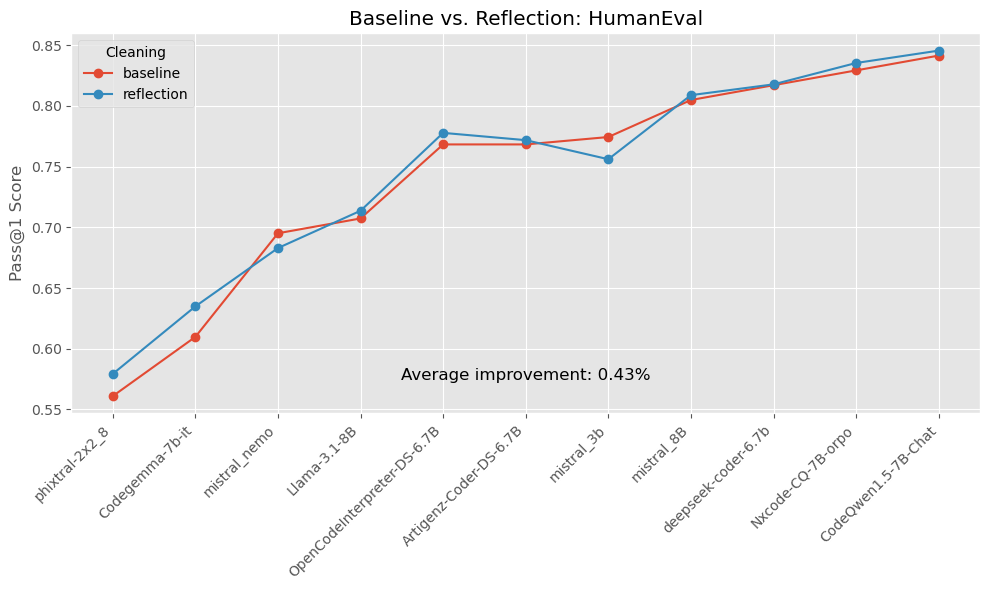

In [161]:
# plot using the max values
plt.style.use('ggplot')
baseline   = 'HumanEval'    #'HumanEval'   'MBPP'  'LBPP'  'BigCode'   
reflection = baseline + '_Reflection'

sorted_models = res_raw_short[baseline].columns
y1 = res_raw_short[baseline].loc[('max', 'max')].values
y2 = res_raw_short[reflection].loc[('max', 'max')].values
improvement = (sum(y2)-sum(y1))/11
phrase = f'Average improvement: {round(improvement*100, 2)}%'

# sort by y1
sorted_indices = y1.argsort()
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
models_sorted = sorted_models[sorted_indices]

plt.figure(figsize=(10, 6))
for label, points in [('baseline', y1_sorted), ('reflection', y2_sorted)]:
    plt.plot(range(len(models_sorted)), points, marker='o', label=label)
plt.title(f'Baseline vs. Reflection: {baseline}')
plt.xticks(range(len(models_sorted)), labels=models_sorted, rotation=45, ha='right')
plt.ylabel('Pass@1 Score')
plt.legend(title='Cleaning')

plt.text(0.5, 0.1, phrase, transform=plt.gca().transAxes,
         fontsize=12, ha='center', va='center',)# fontweight='bold')

plt.tight_layout()
plt.show()

In [155]:
res_raw_short.keys()

dict_keys(['HumanEval', 'BigCode', 'MBPP', 'LBPP', 'HumanEval_Reflection', 'BigCode_Reflection', 'MBPP_Reflection', 'LBPP_Reflection'])

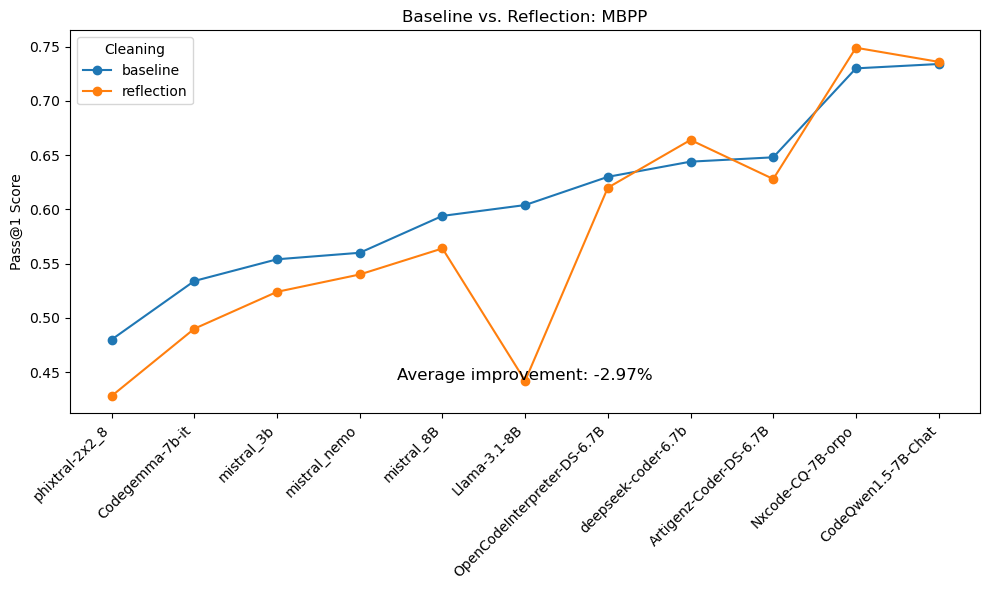

In [156]:
# plot using the most frequent indices
baseline   = 'MBPP'    #'LBPP'    #'HumanEval'
reflection = baseline + '_Reflection'

sorted_models = res_raw_short[baseline].columns
y1 = res_raw_short[baseline].loc[('basic_prompt', 'full')].values
y2 = res_raw_short[reflection].loc[('basic_prompt', 'full_light')].values
improvement = (sum(y2)-sum(y1))/11
phrase = f'Average improvement: {round(improvement*100, 2)}%'

# sort by y1
sorted_indices = y1.argsort()
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
models_sorted = sorted_models[sorted_indices]

plt.figure(figsize=(10, 6))
for label, points in [('baseline', y1_sorted), ('reflection', y2_sorted)]:
    plt.plot(range(len(models_sorted)), points, marker='o', label=label)
plt.title(f'Baseline vs. Reflection: {baseline}')
plt.xticks(range(len(models_sorted)), labels=models_sorted, rotation=45, ha='right')
plt.ylabel('Pass@1 Score')
plt.legend(title='Cleaning')

plt.text(0.5, 0.1, phrase, transform=plt.gca().transAxes,
         fontsize=12, ha='center', va='center',)# fontweight='bold')

plt.tight_layout()
plt.show()